In [1]:
from xgboost import XGBRegressor as XGBR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.linear_model import LinearRegression as LinearR
from sklearn.datasets import load_boston
from sklearn.model_selection import KFold, cross_val_score as CVS, train_test_split as TTS
from sklearn.metrics import mean_squared_error as MSE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
import datetime
import seaborn as sns
sns.set()

In [2]:
data = load_boston()

c:\Program Files\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset 

In [3]:
X = data.data
y = data.target

In [4]:
X.shape

(506, 13)

In [5]:
y.shape

(506,)

## 确定参数

In [6]:
cv = KFold(n_splits=5, shuffle = True, random_state=42) #交叉验证模式

100 0.8925251830201246 0.0007451946196913434
50 0.8922946955456952 0.0007243762662393353
100 0.8925251830201246 0.0007451946196913434 0.012296030904549051


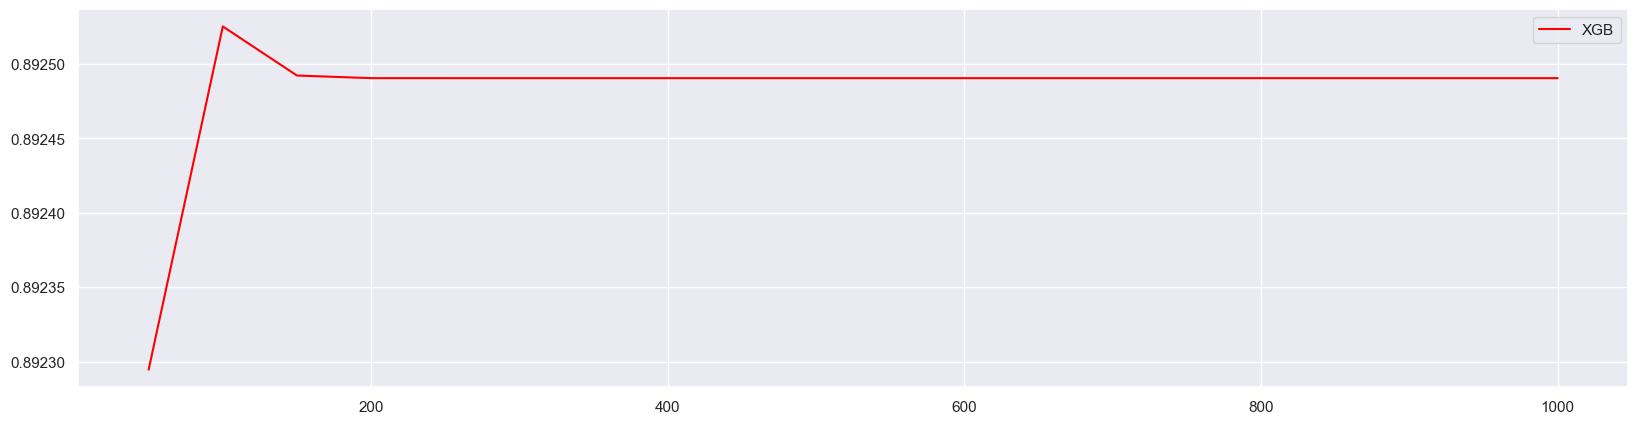

In [7]:
axisx = range(50, 1050, 50)
rs = []
var = []
ge = []
for i in axisx:
    reg = XGBR(n_estimators=i, random_state=420)
    cvresult = CVS(reg, X, y, cv=cv)
    #记录1-偏差
    rs.append(cvresult.mean())
    #记录方差
    var.append(cvresult.var())
    #计算泛化误差的可控部分
    ge.append((1 - cvresult.mean())**2 + cvresult.var())
#打印R2最高所对应的参数取值，并打印这个参数下的方差
print(axisx[rs.index(max(rs))], max(rs), var[rs.index(max(rs))])
#打印方差最低时对应的参数取值，并打印这个参数下的R2
print(axisx[var.index(min(var))], rs[var.index(min(var))], min(var))
#打印泛化误差可控部分的参数取值，并打印这个参数下的R2，方差以及泛化误差的可控部分
print(axisx[ge.index(min(ge))],rs[ge.index(min(ge))],var[ge.index(min(ge))],min(ge))
plt.figure(figsize=(20, 5), dpi=100)
plt.plot(axisx, rs, c="red", label="XGB")
plt.legend()
plt.show()

104 0.8925332337714689 0.0007451047520550104
83 0.8924831111994822 0.0007415086712334032
91 0.8925270726305257 0.0007427745719738076 0.012293204689338113


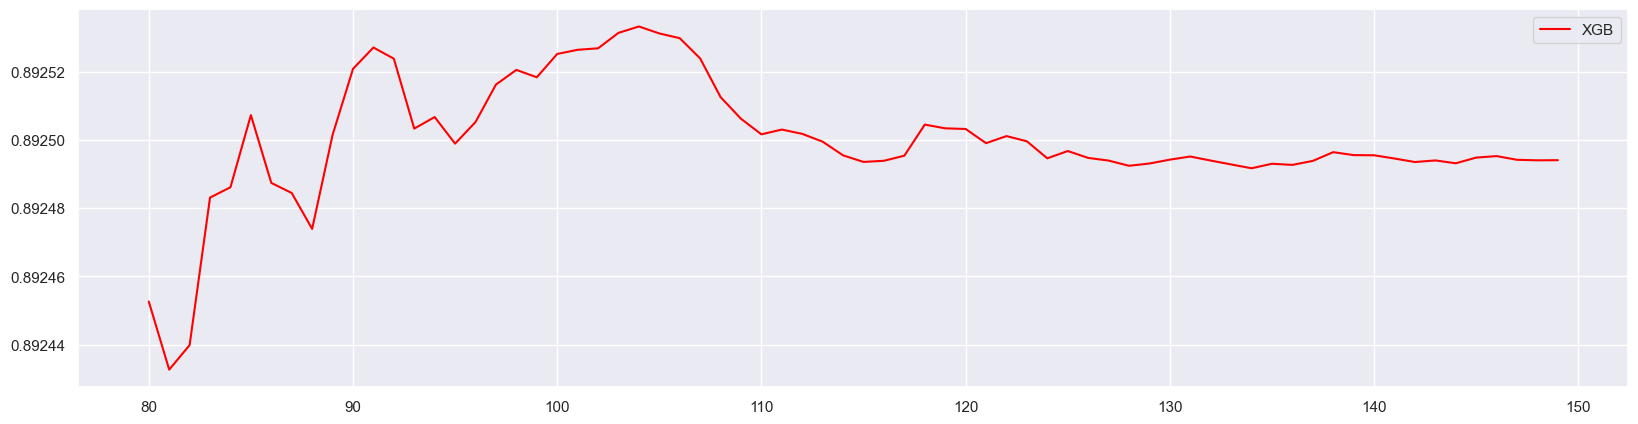

In [8]:
#======【TIME WARNING: 20s】=======#
axisx = range(80, 150, 1)
rs = []
var = []
ge = []
for i in axisx:
    reg = XGBR(n_estimators=i, random_state=420)
    cvresult = CVS(reg, X, y, cv=cv)
    #记录1-偏差
    rs.append(cvresult.mean())
    #记录方差
    var.append(cvresult.var())
    #计算泛化误差的可控部分
    ge.append((1 - cvresult.mean())**2 + cvresult.var())
#打印R2最高所对应的参数取值，并打印这个参数下的方差
print(axisx[rs.index(max(rs))], max(rs), var[rs.index(max(rs))])
#打印方差最低时对应的参数取值，并打印这个参数下的R2
print(axisx[var.index(min(var))], rs[var.index(min(var))], min(var))
#打印泛化误差可控部分的参数取值，并打印这个参数下的R2，方差以及泛化误差的可控部分
print(axisx[ge.index(min(ge))], rs[ge.index(min(ge))], var[ge.index(min(ge))],min(ge))
plt.figure(figsize=(20, 5), dpi=100)
plt.plot(axisx, rs, c="red", label="XGB")
#添加方差线
# plt.plot(axisx, rs+var, c="red", linestyle='-.')
# plt.plot(axisx, rs-var, c="red", linestyle='-.')
plt.legend()
plt.show()

In [9]:
n = 100
Xtrain, Xtest, Ytrain, Ytest = TTS(X, y, test_size=0.3, random_state=420)
model = XGBR(n_estimators=n).fit(Xtrain,Ytrain)
model.predict(Xtest) 
model.score(Xtest,Ytest) # R^2评估指标
mse_score = MSE(Ytest, model.predict(Xtest))#可以看出均方误差是平均值y.mean()的1/3左右，结果不算好也不算坏
print(mse_score)

8.830916343629323


In [10]:
mse_cvs = CVS(model ,Xtrain, Ytrain, cv=5, scoring='neg_mean_squared_error').mean()
print(mse_cvs)
r2_cvs = CVS(model ,Xtrain, Ytrain, cv=5).mean()
print(r2_cvs)

-16.215644229762717
0.7995062821902295


## 查看特征重要程度

In [11]:
feature_lst = data.feature_names

In [12]:
features_import = pd.DataFrame(feature_lst, columns=['feature'])
features_import['importance'] = model.feature_importances_  # 默认按照gini计算特征重要性
features_import.sort_values('importance', inplace=True)

In [13]:
features_import

,feature,importance
1,ZN,0.004211
3,CHAS,0.005535
11,B,0.008695
2,INDUS,0.014783
6,AGE,0.016797
0,CRIM,0.019022
4,NOX,0.022222
8,RAD,0.040736
7,DIS,0.046987
9,TAX,0.054918


0.004210895858705044 ZN
0.005535365082323551 CHAS
0.008694635704159737 B
0.014783158898353577 INDUS
0.016796858981251717 AGE
0.01902167499065399 CRIM
0.022221960127353668 NOX
0.04073573648929596 RAD
0.046987198293209076 DIS
0.0549175851047039 TAX
0.0668422058224678 PTRATIO
0.3201119005680084 LSTAT
0.3791408836841583 RM


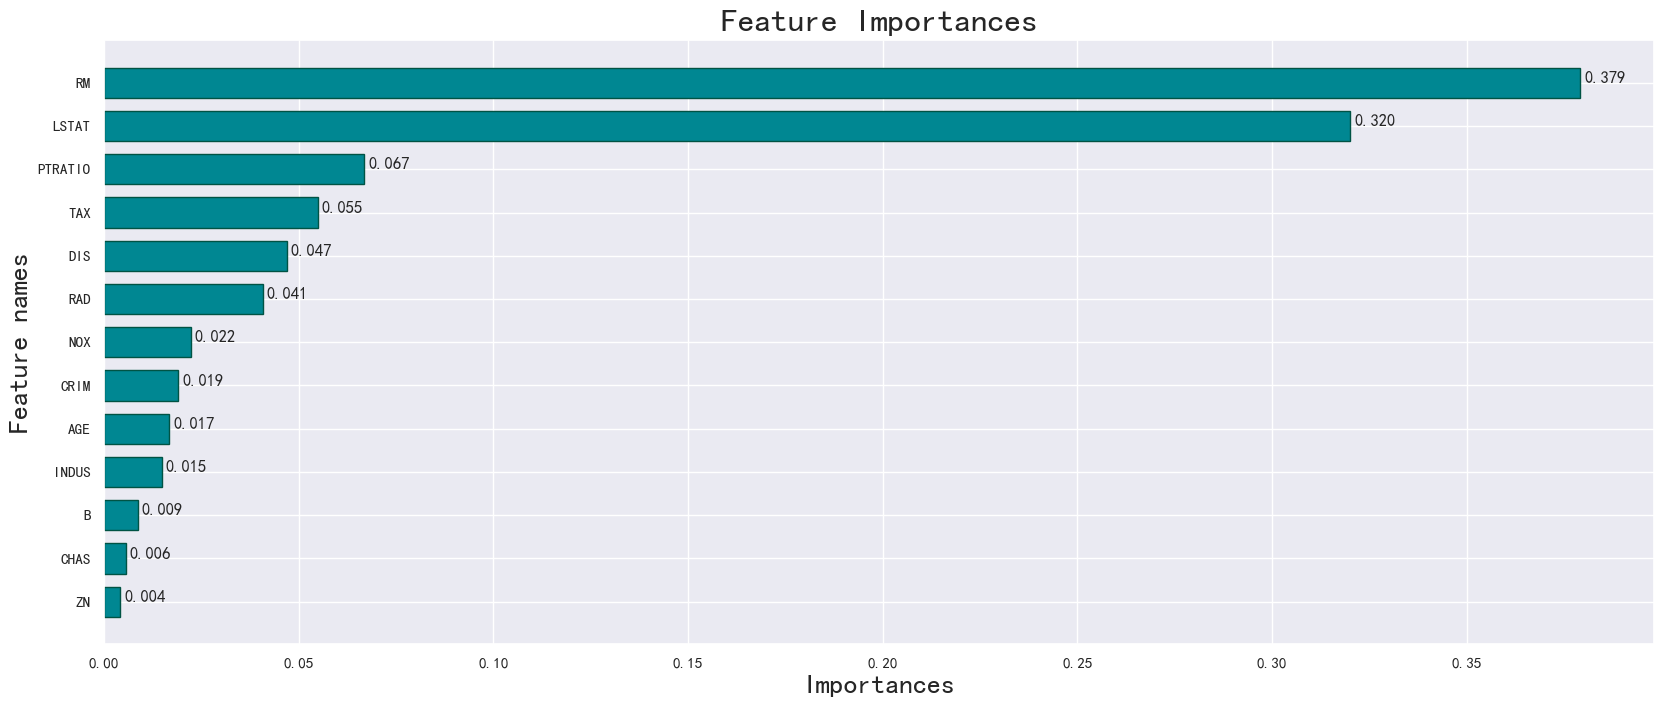

In [14]:
# 绘图
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 8), dpi=100) 

plt.rcParams['font.sans-serif'] = ['SimHei']        # 显示中文黑体
plt.rcParams['axes.unicode_minus'] = False          # 负值显示

plt.barh(features_import['feature'], features_import['importance'], height=0.7, color='#008792', edgecolor='#005344') # 更多颜色可参见颜色大全
plt.xlabel('Importances', fontsize=20)                    # x 轴
plt.ylabel('Feature names', fontsize=20)                              # y轴
plt.title('Feature Importances', fontsize=24)                    # 标题

for a,b in zip( features_import['importance'], features_import['feature']): # 添加数字标签
   print(a,b)
   plt.text(a+0.001, b,'%.3f'%float(a))             # a+0.001代表标签位置在柱形图上方0.001处
plt.show()

## 学习曲线

In [15]:
def plot_learning_curve(estimator,title, X, y, 
                        ax=None, #选择子图
                        ylim=None, #设置纵坐标的取值范围
                        cv=None, #交叉验证
                        n_jobs=None #设定索要使用的线程
                       ):
    
    from sklearn.model_selection import learning_curve
    import matplotlib.pyplot as plt
    import numpy as np
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y
                                                            ,shuffle=True
                                                            ,cv=cv
                                                            ,random_state=420
                                                            ,n_jobs=n_jobs)      
    if ax == None:
        ax = plt.gca()
    else:
        ax = plt.figure()
        
    ax.set_title(title, fontsize=24)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("R2 Score")

    ax.plot(train_sizes, np.mean(train_scores, axis=1), 'o-'
            , color="r",label="Training score")
    ax.plot(train_sizes, np.mean(test_scores, axis=1), 'o-'
            , color="g",label="Test score")
    ax.legend(loc="best")
    return ax

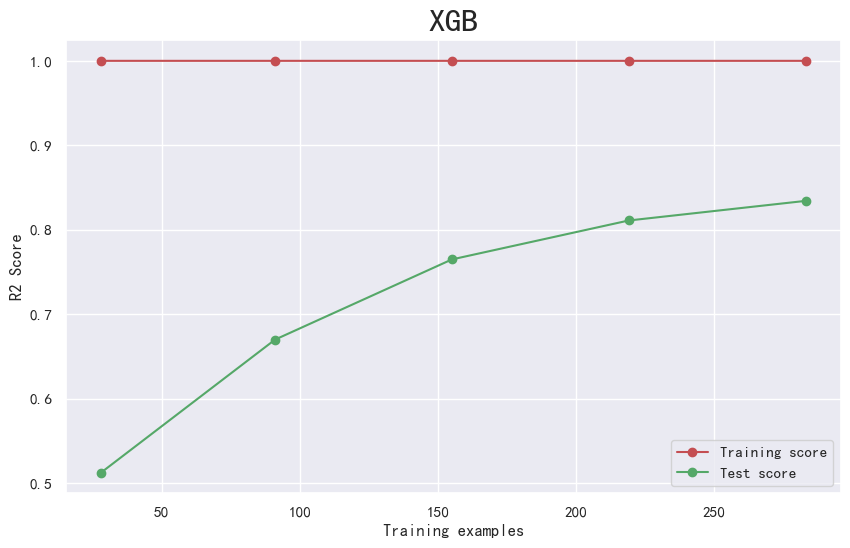

In [19]:
cv = KFold(n_splits=5, shuffle = True, random_state=42) #交叉验证模式
plt.figure(figsize=(10, 6), dpi=100)
plot_learning_curve(XGBR(n_estimators=100, random_state=420)
                    ,"XGB", Xtrain, Ytrain, ax=None, cv=cv)
plt.show()